In [88]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [89]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [90]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [91]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [92]:
tf.keras.backend.clear_session()

In [93]:
subject = 'Amapá - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [94]:
data = pd.read_csv('2003_mo_model_input_AP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Amapá - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,2003-1,0.774101,10518.903600,0.711421,10.392,1.911713,1009.396873,1038.185062,25.663741,22.342619,83.376791,0.991074,2002.738651,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881
1,2003-2,0.774476,10623.124754,0.711553,6.857,1.911107,1009.399285,1039.017226,25.664347,22.345445,83.386754,0.991161,2002.769719,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071
2,2003-3,0.774851,10723.388458,0.711685,7.011,1.910754,1009.400692,1039.502655,25.664701,22.347093,83.392567,0.991211,2002.787842,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261
3,2003-4,0.775226,10817.834529,0.711817,7.122,1.910716,1009.400843,1039.554665,25.664739,22.347270,83.393189,0.991217,2002.789784,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450
4,2003-5,0.775601,10909.780391,0.711949,5.267,1.916050,1009.387499,1037.181846,25.655947,22.352711,83.458581,0.991472,2002.830344,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37300.779456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,37265.020607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,37205.249516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,37124.790031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


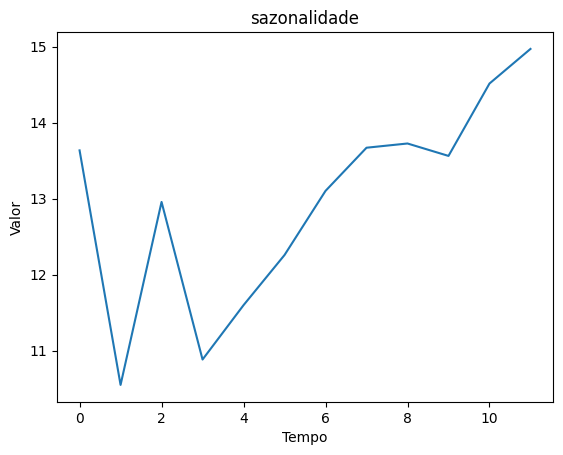

,sazonalidade
sazonalidade,
0,13.634777
1,10.550816
2,12.956791
3,10.884889
4,11.599757
5,12.259207
6,13.102367
7,13.669907
8,13.725451


In [95]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [96]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade,Amapá - Consumo de Cimento (t)
0,2003-1,0.774101,10518.903600,0.711421,1.911713,1009.396873,1038.185062,25.663741,22.342619,83.376791,0.991074,2002.738651,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881,13.634777,10.392
1,2003-2,0.774476,10623.124754,0.711553,1.911107,1009.399285,1039.017226,25.664347,22.345445,83.386754,0.991161,2002.769719,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071,10.550816,6.857
2,2003-3,0.774851,10723.388458,0.711685,1.910754,1009.400692,1039.502655,25.664701,22.347093,83.392567,0.991211,2002.787842,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261,12.956791,7.011
3,2003-4,0.775226,10817.834529,0.711817,1.910716,1009.400843,1039.554665,25.664739,22.347270,83.393189,0.991217,2002.789784,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450,10.884889,7.122
4,2003-5,0.775601,10909.780391,0.711949,1.916050,1009.387499,1037.181846,25.655947,22.352711,83.458581,0.991472,2002.830344,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640,11.599757,5.267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37300.779456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.599757,NaN
245,2023-6,NaN,37265.020607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.259207,NaN
246,2023-7,NaN,37205.249516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.102367,NaN
247,2023-8,NaN,37124.790031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.669907,NaN


In [97]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      9.759
1      4.782
2      7.803
3      4.400
4      4.460
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Amapá - Consumo de Cimento (t), Length: 249, dtype: float64

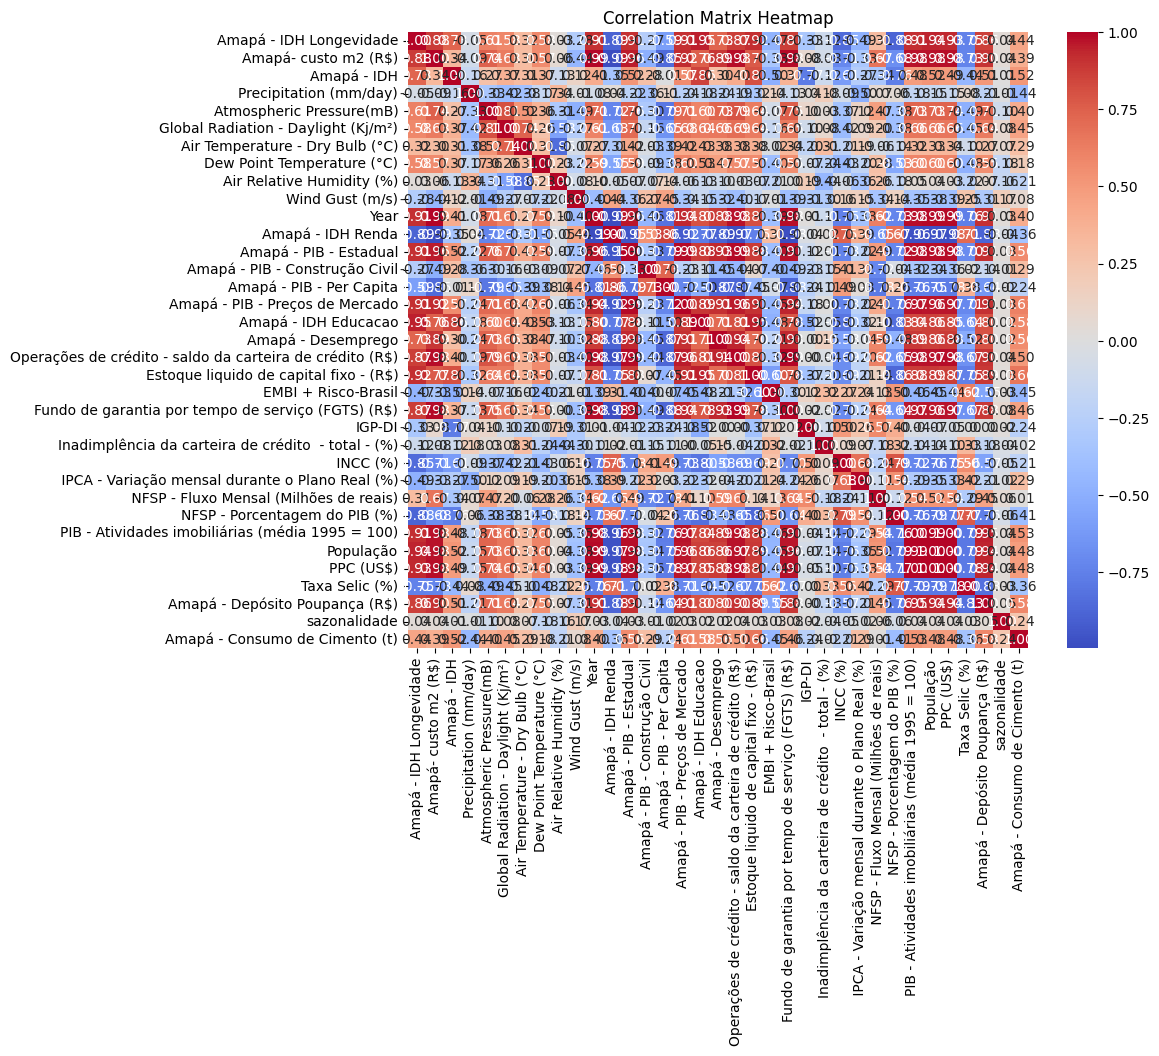

In [98]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [99]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [100]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Amapá - IDH Longevidade,3.470162e+08
1,Amapá- custo m2 (R$),5.462993e+04
2,Amapá - IDH,4.310389e+09
3,Precipitation (mm/day),8.274078e+00
4,Atmospheric Pressure(mB),2.831786e+01
5,Global Radiation - Daylight (Kj/m²),2.250102e+01
6,Air Temperature - Dry Bulb (°C),1.891826e+03
7,Dew Point Temperature (°C),4.930570e+02
8,Air Relative Humidity (%),1.760427e+03
9,Wind Gust (m/s),2.238522e+01


In [101]:
# data =data.drop(['Wind Gust (m/s)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000000)
data

Num columns removed: 0


,Amapá - IDH Longevidade,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$),sazonalidade
0,0.774101,10518.903600,0.711421,1.911713,1009.396873,1038.185062,25.663741,22.342619,83.376791,0.991074,2002.738651,0.689809,8.035813e+06,356591.003430,10.883143,7.033593e+06,0.676675,8.514392,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,205197.602881,13.634777
1,0.774476,10623.124754,0.711553,1.911107,1009.399285,1039.017226,25.664347,22.345445,83.386754,0.991161,2002.769719,0.689704,8.046432e+06,356647.711004,10.885206,7.037356e+06,0.676859,8.508753,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205498.444071,10.550816
2,0.774851,10723.388458,0.711685,1.910754,1009.400692,1039.502655,25.664701,22.347093,83.392567,0.991211,2002.787842,0.689598,8.057052e+06,356704.418579,10.887268,7.041120e+06,0.677044,8.503114,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,205799.285261,12.956791
3,0.775226,10817.834529,0.711817,1.910716,1009.400843,1039.554665,25.664739,22.347270,83.393189,0.991217,2002.789784,0.689493,8.067671e+06,356761.126153,10.889331,7.044883e+06,0.677228,8.497475,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,206100.126450,10.884889
4,0.775601,10909.780391,0.711949,1.916050,1009.387499,1037.181846,25.655947,22.352711,83.458581,0.991472,2002.830344,0.689387,8.078290e+06,356817.833728,10.891394,7.048646e+06,0.677413,8.491835,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,206400.967640,11.599757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0.797224,28470.478785,0.713499,2.680927,1010.619972,1069.687801,24.379457,23.423650,95.165073,0.821961,2018.980331,0.665420,9.534303e+06,350655.766961,10.806700,7.350517e+06,0.685153,15.404462,3.339533e+06,7.711687e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,638584.410637,13.669907
200,0.797003,28695.348842,0.713330,2.743466,1010.589921,1067.835116,24.290571,23.382557,95.421672,0.814759,2018.986821,0.665416,9.524365e+06,350876.967980,10.806465,7.348106e+06,0.684844,15.389494,3.365687e+06,7.707969e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,654707.258685,13.725451
201,0.796781,28931.950319,0.713161,2.788936,1010.560347,1065.954013,24.242086,23.362048,95.571335,0.811732,2019.134027,0.665412,9.514428e+06,351098.168999,10.806230,7.345695e+06,0.684536,15.374527,3.396904e+06,7.704251e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,670830.106733,13.5

In [102]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,-1.596592,-2.714403,-0.158198,-0.146013,-0.266762,0.286923,-1.509546,-1.172393,-0.264607,-1.732340,1.575981,-1.778712,-0.395883,-0.142330,-2.054574,-2.431493,-0.950971,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,-1.706226
1,-1.576672,-2.644890,-0.159181,-0.144049,-0.263583,0.287664,-1.503438,-1.169707,-0.263743,-1.725916,1.562050,-1.759646,-0.387864,-0.105765,-2.021310,-2.388807,-0.952536,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,-1.703829
2,-1.557509,-2.575376,-0.159755,-0.142903,-0.261729,0.288096,-1.499875,-1.168140,-0.263239,-1.722168,1.548119,-1.740579,-0.379845,-0.069199,-1.988046,-2.346120,-0.954101,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,-1.701431
3,-1.539457,-2.505863,-0.159816,-0.142780,-0.261530,0.288143,-1.499494,-1.167972,-0.263185,-1.721767,1.534188,-1.721512,-0.371826,-0.032634,-1.954781,-2.303434,-0.955667,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,-1.699033
4,-1.521883,-2.436350,-0.151158,-0.153647,-0.270595,0.277389,-1.487732,-1.150345,-0.260643,-1.713379,1.520257,-1.702446,-0.363807,0.003932,-1.921517,-2.260748,-0.957232,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,-1.696636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.834545,-1.620409,1.090267,0.850060,-0.146419,-1.283940,0.827119,2.005402,-1.948185,1.626208,-1.647501,0.911846,-1.235180,-1.497273,0.746815,-0.471166,0.961299,1.360064,0.117681,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.378950,1.402207,-1.370268,1.747832
200,1.877525,-1.709397,1.191771,0.825588,-0.153496,-1.392661,0.738295,2.074574,-2.019889,1.627550,-1.648052,0.894003,-1.203900,-1.501437,0.725505,-0.542440,0.957145,1.384545,0.092456,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.391539,1.410056,-1.390925,1.876330
201,1.922747,-1.798384,1.265570,0.801503,-0.160682,-1.451966,0.693965,2.114919,-2.050022,1.657990,-1.648604,0.876160,-1.172620,-1.505602,0.704195,-0.613715,0.952991,1.413764,0.067231,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.404128,1.417346,-1.527663,2.004828
202,1.968944,-1.887371,1.313626,0.796373,-0.167937,-1.476016,0.675814,2.131169,-2.070347,1.692346,-1.649155,0.858317,-1.141340,-1.509767,0.682885,-0.684990,0.948836,1.440408,0.042006,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.416717,1.423988,-1.609340,2.133326


In [103]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
0,-1.596592,-2.714403,-0.158198,-0.146013,-0.266762,0.286923,-1.509546,-1.172393,-0.264607,-1.732340,1.575981,-1.778712,-0.395883,-0.142330,-2.054574,-2.431493,-0.950971,-1.405679,-2.469876,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141,-1.706226
1,-1.576672,-2.644890,-0.159181,-0.144049,-0.263583,0.287664,-1.503438,-1.169707,-0.263743,-1.725916,1.562050,-1.759646,-0.387864,-0.105765,-2.021310,-2.388807,-0.952536,-1.405133,-2.431875,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904,-1.703829
2,-1.557509,-2.575376,-0.159755,-0.142903,-0.261729,0.288096,-1.499875,-1.168140,-0.263239,-1.722168,1.548119,-1.740579,-0.379845,-0.069199,-1.988046,-2.346120,-0.954101,-1.405096,-2.393874,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828,-1.701431
3,-1.539457,-2.505863,-0.159816,-0.142780,-0.261530,0.288143,-1.499494,-1.167972,-0.263185,-1.721767,1.534188,-1.721512,-0.371826,-0.032634,-1.954781,-2.303434,-0.955667,-1.404678,-2.355872,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354,-1.699033
4,-1.521883,-2.436350,-0.151158,-0.153647,-0.270595,0.277389,-1.487732,-1.150345,-0.260643,-1.713379,1.520257,-1.702446,-0.363807,0.003932,-1.921517,-2.260748,-0.957232,-1.403356,-2.317871,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281,-1.696636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.451207,-0.516536,0.113107,0.699686,1.326360,0.400876,-0.069639,-0.207412,-1.264981,1.419422,-1.563097,1.089414,-1.495207,-1.405171,0.972821,0.466834,1.025490,1.193119,0.391058,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.238976,1.279826,-1.152820,0.795764
188,1.476487,-0.612728,0.430193,0.509300,0.949605,0.321064,0.008830,-0.083005,-1.037657,1.420764,-1.579206,1.078880,-1.486993,-1.417761,0.957453,0.379019,1.018467,1.206925,0.371698,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.249345,1.291262,-1.253503,0.806280
189,1.502917,-0.708920,0.589904,0.610132,0.586634,0.151123,0.249965,0.208057,-0.902200,1.451204,-1.595315,1.068346,-1.478780,-1.430350,0.942086,0.291203,1.011445,1.227934,0.352338,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.259715,1.301919,-1.425444,0.816797
190,1.530387,-0.805112,0.204341,0.732778,0.203048,-0.151439,0.544059,0.637982,-0.587871,1.485560,-1.611424,1.057813,-1.470566,-1.442940,0.926719,0.203388,1.004422,1.246115,0.332977,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.270085,1.311660,-1.237935,0.827314


In [104]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       9.759
1       4.782
2       7.803
3       4.400
4       4.460
        ...  
187    13.388
188    13.605
189    13.889
190    11.829
191    12.962
Name: Amapá - Consumo de Cimento (t), Length: 192, dtype: float64

In [105]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [106]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 32)

In [107]:
# input para treinamento
test_input = input_data.iloc[train_split-window_size:split_index + 1]
test_input

,Amapá- custo m2 (R$),Amapá - IDH,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Amapá - IDH Renda,Amapá - PIB - Estadual,Amapá - PIB - Construção Civil,Amapá - PIB - Per Capita,Amapá - PIB - Preços de Mercado,Amapá - IDH Educacao,Amapá - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Amapá - Depósito Poupança (R$)
156,0.930883,1.472119,-0.186668,0.895356,0.150832,0.311119,0.888887,0.074072,0.424729,0.948559,-1.043702,1.117400,-1.313573,-1.318566,1.001247,1.555281,1.248617,1.222613,0.845472,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.903734,0.911463,0.407265,0.533234
157,0.944335,1.417790,0.146888,0.930513,-0.021015,0.379961,1.521304,0.381398,-0.216601,0.965375,-1.063740,1.122750,-1.341957,-1.312930,1.010221,1.528860,1.240539,1.211968,0.833972,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.914718,0.922870,0.137084,0.531052
158,0.958294,1.363461,0.438626,1.191891,0.034641,0.356115,1.634085,0.469727,-0.608405,0.979685,-1.083777,1.128101,-1.370340,-1.307294,1.019196,1.502439,1.232460,1.202030,0.822472,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.925702,0.935360,0.296087,0.528869
159,0.971918,1.309133,0.735269,1.304785,0.141490,0.312692,1.605812,0.494147,-1.158975,0.990470,-1.103814,1.133452,-1.398724,-1.301658,1.028170,1.476018,1.224382,1.192181,0.810972,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.936687,0.948135,0.197300,0.526687
160,0.985405,1.254804,0.651996,1.541650,0.408472,0.418935,1.393961,0.250822,-1.417511,0.996457,-1.123852,1.138803,-1.427108,-1.296022,1.037145,1.449597,1.216304,1.183708,0.799472,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.947671,0.961143,0.469403,0.524504
161,0.998969,1.200475,0.498656,1.603463,0.765568,0.566029,0.831590,-0.228350,-1.256134,1.000898,-1.143889,1.144154,-1.455492,-1.290386,1.046119,1.423176,1.208226,1.174004,0.787972,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.958655,0.973478,0.775434,0.522322
162,1.012823,1.146146,0.058836,1.271533,1.091167,0.864406,0.210720,-0.861143,-0.932438,1.003928,-1.163927,1.149504,-1.483875,-1.284749,1.055094,1.396756,1.200148,1.166949,0.776472,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.969639,0.985778,0.136553,0.520139
163,1.026987,1.091818,-0.028027,0.874661,1.291558,1.173560,-0.349355,-1.426710,-0.491195,1.005851,-1.183964,1.154855,-1.512259,-1.279113,1.064069,1.370335,1.192070,1.159632,0.764972,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.980624,0.999021,0.642038,0.517957
164,1.041067,1.037489,-0.033723,0.524240,1.134483,1.112125,-0.550692,-1.435554,-0.332675,1.007193,-1.204002,1.160206,-1.540643,-1.273477,1.073043,1.343914,1.183992,1.154709,0.753473,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,0.991608,1.012408,0.482412,0.515774
165,1.055980,0.983160,0.163089,0.268162,0.797256,0.809432,-0.625452,-1.130051,-0.403129,1.037633,-1.224039,1.165557,-1.569027,-1.267841,1.082018,1.317493,1.175913,1.151483,0.741973,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.002592,1.025524,0.367764,0.513592


In [108]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 32)

In [109]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [110]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.21,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [111]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [112]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3016096257, 228607498, 2672794966, 443679396, 97669157, 2322846153, 1062249529, 1056260141, 1155756908, 4153216578]


Step: 0 ___________________________________________
val_loss: 4.8081560134887695
winner_seed: 3016096257


Step: 1 ___________________________________________
val_loss: 4.29691743850708
winner_seed: 228607498


Step: 2 ___________________________________________
val_loss: 4.43477201461792


Step: 3 ___________________________________________
val_loss: 5.7660040855407715


Step: 4 ___________________________________________
val_loss: 6.1195454597473145


Step: 5 ___________________________________________
val_loss: 5.348927974700928


Step: 6 ___________________________________________
val_loss: 90.7712173461914


Step: 7 ___________________________________________
val_loss: 4.283846855163574
winner_seed: 1056260141


Step: 8 ___________________________________________
val_loss: 4.162325859069824
winner_seed: 1155756908


Step: 9 ________________________________________

In [113]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2963195227

Epoch 1/10000
4/4 [==============================] - 2s 112ms/step - loss: 232.2524 - val_loss: 76.4438
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 102.7372 - val_loss: 8.1501
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.6399 - val_loss: 15.2160
Epoch 4/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.4744 - val_loss: 83.8991
Epoch 5/10000
4/4 [==============================] - 0s 8ms/step - loss: 20.1703 - val_loss: 108.5631
Epoch 6/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.9745 - val_loss: 122.4583
Epoch 7/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.4013 - val_loss: 96.0631
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 11.9943 - val_loss: 94.4803
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.8784 - val_loss: 41.5941
Epoch 10/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.5340 - va

4/4 [==============================] - 0s 9ms/step - loss: 6.7873 - val_loss: 72.4414
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.2698 - val_loss: 81.3976
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8586 - val_loss: 58.9247
Epoch 85/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4720 - val_loss: 78.8062
Epoch 86/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9095 - val_loss: 53.4605
Epoch 87/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9404 - val_loss: 56.8950
Epoch 88/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.1295 - val_loss: 69.5545
Epoch 89/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.0535 - val_loss: 46.5002
Epoch 90/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8733 - val_loss: 57.5887
Epoch 91/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.2670 - val_loss: 67.8692
Epoch

4/4 [==============================] - 0s 8ms/step - loss: 5.9829 - val_loss: 53.5960
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9638 - val_loss: 57.8520
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9195 - val_loss: 50.9328
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5232 - val_loss: 47.6026
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.6625 - val_loss: 52.5056
Epoch 167/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0105 - val_loss: 50.2858
Epoch 168/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8189 - val_loss: 60.2335
Epoch 169/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.7347 - val_loss: 48.7343
Epoch 170/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.9658 - val_loss: 36.5874
Epoch 171/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5845 - val_loss: 66.3

4/4 [==============================] - 0s 8ms/step - loss: 5.1641 - val_loss: 42.4631
Epoch 243/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3763 - val_loss: 33.8621
Epoch 244/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0020 - val_loss: 45.7513
Epoch 245/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5684 - val_loss: 39.4066
Epoch 246/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.9558 - val_loss: 50.3833
Epoch 247/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.2771 - val_loss: 44.1634
Epoch 248/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9905 - val_loss: 46.0253
Epoch 249/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.2538 - val_loss: 48.4949
Epoch 250/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.8055 - val_loss: 31.3315
Epoch 251/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0947 - val_loss: 46.6

4/4 [==============================] - 0s 7ms/step - loss: 4.6936 - val_loss: 47.9040
Epoch 323/10000
4/4 [==============================] - 0s 7ms/step - loss: 5.0035 - val_loss: 54.9915
Epoch 324/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6107 - val_loss: 65.1327
Epoch 325/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9322 - val_loss: 60.4375
Epoch 326/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0773 - val_loss: 50.6211
Epoch 327/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6251 - val_loss: 43.2641
Epoch 328/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.0651 - val_loss: 46.2654
Epoch 329/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.9165 - val_loss: 54.5474
Epoch 330/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7607 - val_loss: 49.8685
Epoch 331/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6462 - val_loss: 49.3

4/4 [==============================] - 0s 7ms/step - loss: 4.3952 - val_loss: 57.0110
Epoch 403/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.7058 - val_loss: 57.5615
Epoch 404/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.5614 - val_loss: 46.0565
Epoch 405/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.2381 - val_loss: 47.9728
Epoch 406/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4006 - val_loss: 52.2870
Epoch 407/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3223 - val_loss: 40.8214
Epoch 408/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4883 - val_loss: 58.2538
Epoch 409/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7119 - val_loss: 47.0409
Epoch 410/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5357 - val_loss: 50.1502
Epoch 411/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3924 - val_loss: 46.7

4/4 [==============================] - 0s 8ms/step - loss: 4.3621 - val_loss: 60.9251
Epoch 483/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.5513 - val_loss: 61.4068
Epoch 484/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4801 - val_loss: 53.6650
Epoch 485/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.6318 - val_loss: 54.8121
Epoch 486/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0867 - val_loss: 61.4715
Epoch 487/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2717 - val_loss: 59.9914
Epoch 488/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3074 - val_loss: 58.6769
Epoch 489/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2206 - val_loss: 56.7482
Epoch 490/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.3499 - val_loss: 63.5602
Epoch 491/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1417 - val_loss: 61.0

4/4 [==============================] - 0s 8ms/step - loss: 4.0557 - val_loss: 50.0634
Epoch 563/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1233 - val_loss: 57.2476
Epoch 564/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0866 - val_loss: 54.0486
Epoch 565/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9675 - val_loss: 52.2962
Epoch 566/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0617 - val_loss: 54.0768
Epoch 567/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9009 - val_loss: 55.6867
Epoch 568/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9433 - val_loss: 48.9968
Epoch 569/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0829 - val_loss: 46.7338
Epoch 570/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.2111 - val_loss: 58.5635
Epoch 571/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4876 - val_loss: 54.4

4/4 [==============================] - 0s 9ms/step - loss: 3.9457 - val_loss: 43.5700
Epoch 643/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.3654 - val_loss: 48.9282
Epoch 644/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.1366 - val_loss: 45.4867
Epoch 645/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.8673 - val_loss: 44.5958
Epoch 646/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9769 - val_loss: 42.5319
Epoch 647/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7736 - val_loss: 45.7028
Epoch 648/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.0429 - val_loss: 47.7155
Epoch 649/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9920 - val_loss: 39.1737
Epoch 650/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.9608 - val_loss: 43.3946
Epoch 651/10000
4/4 [==============================] - 0s 7ms/step - loss: 4.1963 - val_loss: 47.0

4/4 [==============================] - 0s 8ms/step - loss: 3.7282 - val_loss: 34.6089
Epoch 723/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8803 - val_loss: 42.8973
Epoch 724/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.6534 - val_loss: 40.0119
Epoch 725/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6893 - val_loss: 41.2686
Epoch 726/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8774 - val_loss: 41.3719
Epoch 727/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6387 - val_loss: 42.7822
Epoch 728/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.9180 - val_loss: 44.9466
Epoch 729/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7730 - val_loss: 45.4052
Epoch 730/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.7158 - val_loss: 39.3157
Epoch 731/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8786 - val_loss: 39.7

4/4 [==============================] - 0s 7ms/step - loss: 3.6417 - val_loss: 30.8627
Epoch 803/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6107 - val_loss: 35.8409
Epoch 804/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4710 - val_loss: 39.5573
Epoch 805/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5375 - val_loss: 31.2725
Epoch 806/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5548 - val_loss: 28.7087
Epoch 807/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3980 - val_loss: 31.4502
Epoch 808/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5965 - val_loss: 26.9044
Epoch 809/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5617 - val_loss: 33.9762
Epoch 810/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.8771 - val_loss: 26.7549
Epoch 811/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5880 - val_loss: 24.3

4/4 [==============================] - 0s 7ms/step - loss: 3.3434 - val_loss: 19.9485
Epoch 883/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6936 - val_loss: 15.0260
Epoch 884/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3629 - val_loss: 22.4847
Epoch 885/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6189 - val_loss: 22.7846
Epoch 886/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3003 - val_loss: 24.5634
Epoch 887/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7117 - val_loss: 25.0579
Epoch 888/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.7984 - val_loss: 26.4005
Epoch 889/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2885 - val_loss: 21.6450
Epoch 890/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.5353 - val_loss: 23.4453
Epoch 891/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3601 - val_loss: 28.8

4/4 [==============================] - 0s 8ms/step - loss: 3.1768 - val_loss: 20.1817
Epoch 963/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3537 - val_loss: 18.3621
Epoch 964/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2180 - val_loss: 17.2705
Epoch 965/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1977 - val_loss: 18.5919
Epoch 966/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.6129 - val_loss: 18.2702
Epoch 967/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2874 - val_loss: 16.8445
Epoch 968/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0191 - val_loss: 18.9241
Epoch 969/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1302 - val_loss: 18.0637
Epoch 970/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4210 - val_loss: 14.9422
Epoch 971/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4813 - val_loss: 16.6

4/4 [==============================] - 0s 8ms/step - loss: 3.1007 - val_loss: 14.3275
Epoch 1043/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4233 - val_loss: 16.7867
Epoch 1044/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.5065 - val_loss: 16.6927
Epoch 1045/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2406 - val_loss: 13.3145
Epoch 1046/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1980 - val_loss: 14.1944
Epoch 1047/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0265 - val_loss: 12.7677
Epoch 1048/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2818 - val_loss: 15.3081
Epoch 1049/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2811 - val_loss: 15.2862
Epoch 1050/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0819 - val_loss: 13.8819
Epoch 1051/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2958 - val_l

Epoch 1122/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8372 - val_loss: 9.2315
Epoch 1123/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.9734 - val_loss: 10.5826
Epoch 1124/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0505 - val_loss: 10.2969
Epoch 1125/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2252 - val_loss: 9.2466
Epoch 1126/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.0614 - val_loss: 10.0255
Epoch 1127/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1614 - val_loss: 8.3653
Epoch 1128/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.2593 - val_loss: 10.0850
Epoch 1129/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1700 - val_loss: 8.6151
Epoch 1130/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1267 - val_loss: 8.8089
Epoch 1131/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.

4/4 [==============================] - 0s 8ms/step - loss: 3.1265 - val_loss: 7.8707
Epoch 1203/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0408 - val_loss: 8.2464
Epoch 1204/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1075 - val_loss: 7.8588
Epoch 1205/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.4087 - val_loss: 8.8469
Epoch 1206/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2176 - val_loss: 8.7980
Epoch 1207/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.3148 - val_loss: 10.0870
Epoch 1208/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8879 - val_loss: 9.0684
Epoch 1209/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0175 - val_loss: 8.0229
Epoch 1210/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.3104 - val_loss: 7.7157
Epoch 1211/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9017 - val_loss: 8.1

4/4 [==============================] - 0s 8ms/step - loss: 3.0114 - val_loss: 6.3357
Epoch 1283/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9062 - val_loss: 5.7567
Epoch 1284/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7284 - val_loss: 5.5441
Epoch 1285/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8504 - val_loss: 6.4710
Epoch 1286/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4372 - val_loss: 5.7380
Epoch 1287/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8414 - val_loss: 5.7645
Epoch 1288/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8505 - val_loss: 5.1011
Epoch 1289/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0901 - val_loss: 5.0855
Epoch 1290/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9063 - val_loss: 5.9466
Epoch 1291/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0090 - val_loss: 5.04

4/4 [==============================] - 0s 8ms/step - loss: 2.7391 - val_loss: 4.6313
Epoch 1363/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0753 - val_loss: 4.8376
Epoch 1364/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2916 - val_loss: 4.6366
Epoch 1365/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.2927 - val_loss: 4.7998
Epoch 1366/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.1325 - val_loss: 4.5802
Epoch 1367/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7392 - val_loss: 4.6644
Epoch 1368/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9205 - val_loss: 4.6271
Epoch 1369/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.9333 - val_loss: 4.5211
Epoch 1370/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7276 - val_loss: 4.6115
Epoch 1371/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8030 - val_loss: 4.32

4/4 [==============================] - 0s 8ms/step - loss: 2.7063 - val_loss: 4.1805
Epoch 1443/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7579 - val_loss: 4.1958
Epoch 1444/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7651 - val_loss: 4.1230
Epoch 1445/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6126 - val_loss: 4.2035
Epoch 1446/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7693 - val_loss: 4.2938
Epoch 1447/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7323 - val_loss: 4.3954
Epoch 1448/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8238 - val_loss: 4.5409
Epoch 1449/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0550 - val_loss: 4.2279
Epoch 1450/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6349 - val_loss: 4.1212
Epoch 1451/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5825 - val_loss: 4.23

4/4 [==============================] - 0s 8ms/step - loss: 2.6970 - val_loss: 6.5597
Epoch 1523/10000
4/4 [==============================] - 0s 7ms/step - loss: 3.1844 - val_loss: 5.7535
Epoch 1524/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6852 - val_loss: 6.8341
Epoch 1525/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5180 - val_loss: 5.5083
Epoch 1526/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6911 - val_loss: 5.2381
Epoch 1527/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.7336 - val_loss: 5.3724
Epoch 1528/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.8097 - val_loss: 4.6666
Epoch 1529/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4474 - val_loss: 6.5198
Epoch 1530/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6888 - val_loss: 5.5015
Epoch 1531/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6912 - val_loss: 5.49

4/4 [==============================] - 0s 8ms/step - loss: 2.6109 - val_loss: 5.2820
Epoch 1603/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.6090 - val_loss: 4.4650
Epoch 1604/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6496 - val_loss: 4.9115
Epoch 1605/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4094 - val_loss: 5.1673
Epoch 1606/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4553 - val_loss: 5.4127
Epoch 1607/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6788 - val_loss: 5.5568
Epoch 1608/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7609 - val_loss: 5.8016
Epoch 1609/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.6352 - val_loss: 5.7419
Epoch 1610/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4131 - val_loss: 4.8830
Epoch 1611/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5567 - val_loss: 5.49

4/4 [==============================] - 0s 7ms/step - loss: 2.4371 - val_loss: 3.9833
Epoch 1683/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3624 - val_loss: 4.3087
Epoch 1684/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4965 - val_loss: 5.5758
Epoch 1685/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.4974 - val_loss: 4.7990
Epoch 1686/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5483 - val_loss: 4.9551
Epoch 1687/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.5912 - val_loss: 7.6828
Epoch 1688/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5062 - val_loss: 4.4227
Epoch 1689/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7345 - val_loss: 4.4542
Epoch 1690/10000
4/4 [==============================] - 0s 8ms/step - loss: 3.0420 - val_loss: 6.3653
Epoch 1691/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.8224 - val_loss: 5.74

4/4 [==============================] - 0s 8ms/step - loss: 2.5242 - val_loss: 3.5418
Epoch 1763/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4331 - val_loss: 4.7275
Epoch 1764/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3363 - val_loss: 6.0991
Epoch 1765/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5212 - val_loss: 6.9879
Epoch 1766/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3240 - val_loss: 5.0202
Epoch 1767/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.7321 - val_loss: 4.5026
Epoch 1768/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2191 - val_loss: 6.1385
Epoch 1769/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3849 - val_loss: 6.3198
Epoch 1770/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3565 - val_loss: 6.2209
Epoch 1771/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3967 - val_loss: 7.28

4/4 [==============================] - 0s 8ms/step - loss: 2.4598 - val_loss: 8.1705
Epoch 1843/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2900 - val_loss: 5.9575
Epoch 1844/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5743 - val_loss: 7.3277
Epoch 1845/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2633 - val_loss: 7.3592
Epoch 1846/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3778 - val_loss: 5.9348
Epoch 1847/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4748 - val_loss: 6.5320
Epoch 1848/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1291 - val_loss: 6.9872
Epoch 1849/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4362 - val_loss: 6.0470
Epoch 1850/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2128 - val_loss: 5.3565
Epoch 1851/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4737 - val_loss: 5.41

4/4 [==============================] - 0s 8ms/step - loss: 2.3750 - val_loss: 3.5727
Epoch 1923/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2859 - val_loss: 3.6440
Epoch 1924/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2798 - val_loss: 4.5488
Epoch 1925/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2521 - val_loss: 4.2052
Epoch 1926/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2457 - val_loss: 4.9519
Epoch 1927/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3430 - val_loss: 4.7877
Epoch 1928/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3426 - val_loss: 5.2820
Epoch 1929/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2971 - val_loss: 4.3996
Epoch 1930/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.2946 - val_loss: 7.2266
Epoch 1931/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1593 - val_loss: 5.07

4/4 [==============================] - 0s 8ms/step - loss: 1.9974 - val_loss: 6.7103
Epoch 2003/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.4029 - val_loss: 5.2872
Epoch 2004/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0633 - val_loss: 4.9031
Epoch 2005/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1441 - val_loss: 4.3611
Epoch 2006/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3151 - val_loss: 5.5221
Epoch 2007/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1172 - val_loss: 3.8863
Epoch 2008/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1039 - val_loss: 3.8412
Epoch 2009/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1719 - val_loss: 3.8357
Epoch 2010/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1099 - val_loss: 3.7306
Epoch 2011/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0746 - val_loss: 4.12

4/4 [==============================] - 0s 7ms/step - loss: 2.0471 - val_loss: 3.9598
Epoch 2083/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0544 - val_loss: 4.3631
Epoch 2084/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.1054 - val_loss: 3.6619
Epoch 2085/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.3430 - val_loss: 3.6830
Epoch 2086/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2181 - val_loss: 3.5180
Epoch 2087/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1452 - val_loss: 2.8156
Epoch 2088/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1440 - val_loss: 3.5418
Epoch 2089/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1140 - val_loss: 4.3437
Epoch 2090/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0813 - val_loss: 3.1914
Epoch 2091/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0753 - val_loss: 2.89

4/4 [==============================] - 0s 8ms/step - loss: 2.0437 - val_loss: 2.9331
Epoch 2163/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0358 - val_loss: 2.9782
Epoch 2164/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0911 - val_loss: 3.6689
Epoch 2165/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.1335 - val_loss: 2.7330
Epoch 2166/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.1667 - val_loss: 2.7075
Epoch 2167/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3088 - val_loss: 2.6739
Epoch 2168/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.1883 - val_loss: 3.1202
Epoch 2169/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0474 - val_loss: 2.8865
Epoch 2170/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9242 - val_loss: 3.0593
Epoch 2171/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8450 - val_loss: 3.41

4/4 [==============================] - 0s 8ms/step - loss: 1.9322 - val_loss: 3.8683
Epoch 2243/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0456 - val_loss: 4.5485
Epoch 2244/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9290 - val_loss: 5.2422
Epoch 2245/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0812 - val_loss: 4.2475
Epoch 2246/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9908 - val_loss: 4.0675
Epoch 2247/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7778 - val_loss: 3.9642
Epoch 2248/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8120 - val_loss: 4.7396
Epoch 2249/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0959 - val_loss: 4.4639
Epoch 2250/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0553 - val_loss: 4.2931
Epoch 2251/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9733 - val_loss: 4.18

4/4 [==============================] - 0s 7ms/step - loss: 1.9975 - val_loss: 2.9618
Epoch 2323/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8787 - val_loss: 2.9905
Epoch 2324/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.9997 - val_loss: 4.5491
Epoch 2325/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0065 - val_loss: 4.2189
Epoch 2326/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9427 - val_loss: 3.7001
Epoch 2327/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8626 - val_loss: 3.5229
Epoch 2328/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8972 - val_loss: 3.4303
Epoch 2329/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.3179 - val_loss: 3.5604
Epoch 2330/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0511 - val_loss: 3.5382
Epoch 2331/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8549 - val_loss: 3.65

4/4 [==============================] - 0s 8ms/step - loss: 1.8610 - val_loss: 5.6200
Epoch 2403/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9055 - val_loss: 5.3018
Epoch 2404/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7851 - val_loss: 4.9326
Epoch 2405/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9849 - val_loss: 6.1561
Epoch 2406/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8008 - val_loss: 5.0754
Epoch 2407/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6436 - val_loss: 6.2760
Epoch 2408/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.0748 - val_loss: 5.8409
Epoch 2409/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.2445 - val_loss: 5.9972
Epoch 2410/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8728 - val_loss: 5.4623
Epoch 2411/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7824 - val_loss: 5.28

4/4 [==============================] - 0s 8ms/step - loss: 2.1122 - val_loss: 5.5959
Epoch 2483/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0139 - val_loss: 6.3827
Epoch 2484/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8018 - val_loss: 7.5522
Epoch 2485/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7859 - val_loss: 6.2529
Epoch 2486/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7165 - val_loss: 6.4824
Epoch 2487/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0082 - val_loss: 5.1721
Epoch 2488/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.7861 - val_loss: 6.1936
Epoch 2489/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.7307 - val_loss: 6.0833
Epoch 2490/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.6383 - val_loss: 6.0232
Epoch 2491/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.9006 - val_loss: 5.96

4/4 [==============================] - 0s 8ms/step - loss: 1.7408 - val_loss: 4.0395
Epoch 2563/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9570 - val_loss: 5.7602
Epoch 2564/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.8959 - val_loss: 4.8077
Epoch 2565/10000
4/4 [==============================] - 0s 7ms/step - loss: 2.0167 - val_loss: 4.0823
Epoch 2566/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.1397 - val_loss: 3.9169
Epoch 2567/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.8511 - val_loss: 3.1625
Epoch 2568/10000
4/4 [==============================] - 0s 8ms/step - loss: 2.5935 - val_loss: 3.2610
Epoch 2569/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.9335 - val_loss: 5.0953
Epoch 2570/10000
4/4 [==============================] - 0s 7ms/step - loss: 1.9519 - val_loss: 4.1567
Epoch 2571/10000
4/4 [==============================] - 0s 8ms/step - loss: 1.7820 - val_loss: 3.30

In [114]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [115]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,12.191929,12.562169,13.095246,13.519494,13.778622,14.070291,14.364846,14.480935,14.404384,14.177386,14.228515,14.276723
Target,11.136,9.216,12.152,12.958,12.879,13.924,15.125,14.239,11.738,14.325,15.301,14.628
Error,1.055929,3.346169,0.943246,0.561494,0.899622,0.146291,0.760154,0.241935,2.666384,0.147614,1.072485,0.351277


In [116]:
display(mae)
display(mape)

1.01605

0.08816942

In [117]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [118]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[165.15053]] - Target[157.62099999999998]| =  Error: [[7.5295258]]; MAPE:[[0.04776981]]


[array([[7.5295258]], dtype=float32)]

7.5295258

0.04776981